Esteban Castañeda Blanco C01795

Israel López Vallecillo C04396

Daniel Lizano Morales C04285

Ariel Solís Monge B97664

## Imports and config

In [1]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import config

In [2]:
if config.USE_UNET: import unet as autoencoder
else: import convolutional_autoencoder as autoencoder

In [3]:
labeled_train_relative_set_size = round((config.LABELED_TRAIN_SET_ABSOLUTE_SIZE / (1 - config.UNLABELED_SET_SIZE)), 2)
labeled_test_relative_set_size = 1 - labeled_train_relative_set_size

In [4]:
# Set up of the device
if torch.backends.mps.is_available():
    device = torch.device("mps")#tqm
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


## Datasets and dataloaders

In [7]:
data_transforms = {
    'bce': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'mse': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.4543, std=0.1757)
    ])
}

In [8]:
full_dataset = datasets.ImageFolder(config.BASE_DIR_RAW, transform=data_transforms[config.AE_TRANSFORMS])
full_noisy_dataset = datasets.ImageFolder(config.BASE_DIR_NOISY, transform=data_transforms[config.AE_TRANSFORMS])

In [9]:
indices = list(range(len(full_dataset)))
noisy_indices =list(range(len(full_noisy_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]
noisy_image_paths = [sample[0] for sample in full_noisy_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]
noisy_labels = [os.path.split(os.path.dirname(path))[-1] for path in noisy_image_paths]

In [12]:
#Obtenemos el 20% de los datos 
train_val_indices, _  = train_test_split(indices, test_size=config.UNLABELED_SET_SIZE, stratify=labels, random_state=42)#Obtenemos el 20% de los datos 
noisy_train_val_indices, _ = train_test_split(noisy_indices, test_size=config.UNLABELED_SET_SIZE, stratify=noisy_labels, random_state=42)

#Obtenemos las etiquetas de los datos de entrenamiento
train_val_labels = [labels[i] for i in train_val_indices]
noisy_train_val_labels = [noisy_labels[i] for i in noisy_train_val_indices]

#dividir el 20% en 10% de entrenamiento y 10% de validación
train_indices, val_indices = train_test_split(train_val_indices, test_size=labeled_test_relative_set_size, stratify=train_val_labels, random_state=42)
noisy_train_indices, noisy_val_indices = train_test_split(noisy_train_val_indices, test_size=labeled_test_relative_set_size, stratify=noisy_train_val_labels, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
noisy_train_dataset = Subset(full_noisy_dataset, noisy_train_indices)
val_dataset = Subset(full_dataset, val_indices)
noisy_val_dataset = Subset(full_dataset, noisy_val_indices)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
noisy_loader = DataLoader(noisy_train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
noisy_val_loader = DataLoader(noisy_val_dataset, batch_size=4, shuffle=False, num_workers=4)

print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_loader.dataset)}")
print(f"Número de imágenes en el conjunto de entrenamiento: {len(noisy_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(noisy_val_loader.dataset)}")

Número de imágenes en el conjunto de entrenamiento: 6148
Número de imágenes en el conjunto de entrenamiento: 6148
Número de imágenes en el conjunto de validación: 6149
Número de imágenes en el conjunto de validación: 6149


## Function definitions

In [10]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [11]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), config.CNN_ENCODER_SAVE_PATH)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    
    return model

In [12]:
def evaluate_model(model_path, dataloader, device):
    model = models.efficientnet_b2(pretrained=False)
    new_in_channels = 1
    original_conv1 = model.features[0][0]

    new_conv1 = nn.Conv2d(
        in_channels=new_in_channels,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias
    )
    with torch.no_grad():
        if new_in_channels == 1:
            new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
        else:
            new_conv1.weight[:, :3] = original_conv1.weight
            if new_in_channels > 3:
                for i in range(3, new_in_channels):
                    new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)
    model.features[0][0] = new_conv1
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names=dataloader.dataset.dataset.classes)
    class_names = dataloader.dataset.dataset.classes
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print(f'Overall Accuracy: {accuracy:.4f}')
    print("\nMetrics by Class:")
    print("{:<20} {:<10} {:<10} {:<10}".format("Class", "Accuracy", "Precision", "Recall"))
    print("="*50)
    for class_name, class_accuracy, class_precision, class_recall in zip(class_names, class_accuracies, precision, recall):
        print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(class_name, class_accuracy, class_precision, class_recall))
    
    return accuracy

In [13]:
# Load the encoder model
def load_encoder(model_path, device):
    model = autoencoder.AutoEncoder()
    model.load_state_dict(torch.load(model_path, map_location=device))
    encoder = model.encoder
    encoder = encoder.to(device)
    return model, encoder

## Encoder + CNN Classifier

In [14]:
cnn_model = models.efficientnet_b2()

# Modify the first convolutional layer to accept a different number of input channels (e.g., 1 instead of 3)
new_in_channels = config.LATENT_CHANNELS  # Change this to the desired number of input channels
original_conv1 = cnn_model.features[0][0]

new_conv1 = nn.Conv2d(
    in_channels=new_in_channels,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias
)

# Initialize the weights of the new conv layer
with torch.no_grad():
    if new_in_channels == 1:
        # Average the weights of the original conv layer across the input channels
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
    else:
        # Initialize weights by repeating the mean weights or use a different strategy
        new_conv1.weight[:, :3] = original_conv1.weight
        if new_in_channels > 3:
            for i in range(3, new_in_channels):
                new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)

# Replace the first convolutional layer in the model
cnn_model.features[0][0] = new_conv1

# Print the modified first convolutional layer
print("Modified first conv layer:", cnn_model.features[0][0])
# model._conv_stem = nn.Conv2d(1, model._conv_stem.out_channels, kernel_size=model._conv_stem.kernel_size, stride=model._conv_stem.stride, padding=model._conv_stem.padding, bias=False)

Using device: cuda
Modified first conv layer: Conv2d(512, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


In [15]:
class EncoderCNN(nn.Module):
    def __init__(self, encoder_model, cnn_model):
        super(EncoderCNN, self).__init__()
        self.encoder = encoder_model
        self.cnn = cnn_model
    

    def forward(self, x):
        _, _, _, _, x = self.encoder(x)
        output = self.cnn(x)
        return output

In [16]:
autoencoder, encoder_model = load_encoder(config.AUTOENCODER_SAVE_PATH, device)

In [17]:
model = EncoderCNN(encoder_model, cnn_model)
model = model.to(device)
model.encoder.requires_grad_(config.TRAIN_ENCODER_WEIGHTS)

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
criterion = config.LOSS_FUNCTION
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

### Training

In [ ]:
if not config.USE_DENOISING_AUTOENCODER:
    train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=config.EPOCHS, patience=config.PATIENCE)
else:
    train_model(model, criterion, optimizer, noisy_loader, noisy_val_loader, device, num_epochs=config.EPOCHS, patience=config.PATIENCE)

In [ ]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

Using device: cuda


### Evaluation

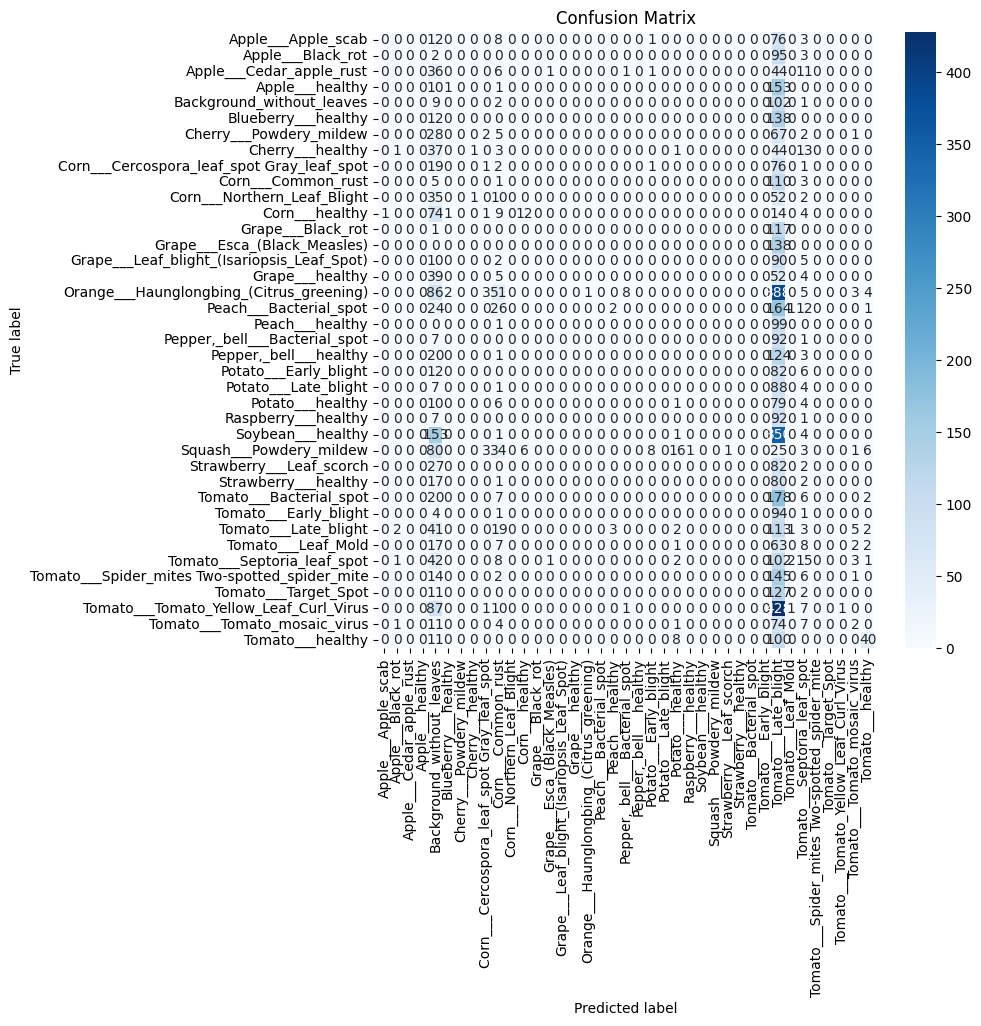

Overall Accuracy: 0.0320

Metrics by Class:
Class                Accuracy   Precision  Recall    
Apple___Apple_scab   0.0000     0.0000     0.0000    
Apple___Black_rot    0.0000     0.0000     0.0000    
Apple___Cedar_apple_rust 0.0000     0.0000     0.0000    
Apple___healthy      0.0000     0.0000     0.0000    
Background_without_leaves 0.0789     0.0087     0.0789    
Blueberry___healthy  0.0000     0.0000     0.0000    
Cherry___Powdery_mildew 0.0000     0.0000     0.0000    
Cherry___healthy     0.0100     0.5000     0.0100    
Corn___Cercospora_leaf_spot Gray_leaf_spot 0.0100     0.0909     0.0100    
Corn___Common_rust   0.0084     0.0043     0.0084    
Corn___Northern_Leaf_Blight 0.0000     0.0000     0.0000    
Corn___healthy       0.1034     0.6667     0.1034    
Grape___Black_rot    0.0000     0.0000     0.0000    
Grape___Esca_(Black_Measles) 0.0000     0.0000     0.0000    
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 0.0000     0.0000     0.0000    
Grape___healthy      

c:\Users\ISRAEL\Documents\Estudios\UCR\Computacion\MachineLearning\proyecto3\plant_disease_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.03203772971214831

In [ ]:
if not config.USE_DENOISING_AUTOENCODER:
    evaluate_model(config.CNN_ENCODER_SAVE_PATH, val_loader, device)
else:
    evaluate_model(config.CNN_ENCODER_SAVE_PATH, noisy_val_loader, device)